In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
import sklearn
from explainerdashboard import RegressionExplainer, ClassifierExplainer, ExplainerDashboard, InlineExplainer

RANDOM_STATE = 123

In [4]:
smt_2020_df = pd.read_excel('data/I11_SMT Incidents 2020.xlsx')

smt_2020_df.columns = smt_2020_df.iloc[11].values
smt_2020_df = smt_2020_df.iloc[12:]
smt_2020_df = smt_2020_df.reset_index(drop=True)


c:\ProgramData\Anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default


In [5]:
smt_2021_df = pd.read_excel('data/I11_SMT Incidents 2021.xlsx')

smt_2021_df.columns = smt_2021_df.iloc[11].values
smt_2021_df = smt_2021_df.iloc[12:]
smt_2021_df = smt_2021_df.reset_index(drop=True)

In [6]:
smt_2022_df = pd.read_excel('data/I11_SMT Incidents 2022.xlsx')

smt_2022_df.columns = smt_2022_df.iloc[11].values
smt_2022_df = smt_2022_df.iloc[12:]
smt_2022_df = smt_2022_df.reset_index(drop=True)

In [7]:
smt_df = pd.concat([smt_2020_df, smt_2021_df, smt_2022_df])
smt_df.reset_index(drop=True,inplace=True)

pd.set_option('display.max_columns', None)

In [8]:
celonis_2020_df = pd.read_excel('data/Tickets_Celonis_2020.xlsx')
celonis_2020_df = celonis_2020_df.reset_index(drop=True)

In [9]:
celonis_2021_df = pd.read_excel('data/Tickets_Celonis_2021.xlsx')
celonis_2021_df = celonis_2021_df.reset_index(drop=True)

In [10]:
celonis_2022_df = pd.read_excel('data/Tickets_Celonis_2022.xlsx')
celonis_2022_df = celonis_2022_df.reset_index(drop=True)

In [11]:
celonis_df = pd.concat([celonis_2020_df, celonis_2021_df, celonis_2022_df])
celonis_df.reset_index(drop=True,inplace=True)

In [12]:
#Posibles a borrar ['Current Incident Type', 'Region', 'Impact', 'Site','Product Categorization Tier 1', 'Resolution Categorization Tier 1', 'Resolution Categorization Tier 2', ]
#Posibles a no borrar ['Customer Department', 'Primary Center Code']

no_borrados_para_analisis = ['Status Reason', 'Customer Department', 'Desk Location', 'Impact', 'Service+', 'CI+', 'Resolution Categorization Tier 3', 'Desk Location']

smt_df_clean = smt_df.drop(['Original Incident Number', 'Requisition ID', 'Created Date (UTC+0)', 'Status', 'Customer Department', 'Summary', 'In Progess Time (hhh:mi)\n', 'Actual Duration/Open Time (hhh:mi)',
                                         'Down Time of CI-Unavailability (hhh:mi)', 'Last Modified Date (UTC+0)', 'First Resolved Date (UTC+0)', 'Last Resolved Date (UTC+0)', 'Product Name', 
                                         'Resolution Product Name', 'Primary Center Code', 'Target Date', 'Notes', 'Resolution'], axis=1)

smt_df_clean.fillna('NaN', inplace=True)

In [13]:
#Posibles a borrar ['Site Group', 'Submitter Group', 'Resolver Organization']
#Posibles a no borrar ['Template Name', 'User Company']
celonis_no_borrados_para_analisis = ['Service Name', 'Template Name', 'User Company', 'CI']

celonis_df_clean = celonis_df.drop(['Submit Date', 'Ticket Summary', 'Last Resolution Date', 'Requisition ID', 'Site', 'Site Group', 'Reported Source', 'Status'], axis=1)
celonis_df_clean.fillna('NaN', inplace=True)

In [14]:
combined_df = pd.merge(celonis_df_clean, smt_df_clean, how='inner', left_on='Incident Number', right_on='Incident ID')
combined_df.drop(['Incident ID'], axis=1, inplace=True) #Comprobar Target Date

In [15]:
"""Q1 = combined_df['Last Resolution Time'].quantile(0.1)
Q3 = combined_df['Last Resolution Time'].quantile(0.9)
IQR = Q3 - Q1

# Filtra las filas que no son outliers
combined_df = combined_df[combined_df['Last Resolution Time'] <= Q3 + 1.5 * IQR]
combined_df.shape"""

"Q1 = combined_df['Last Resolution Time'].quantile(0.1)\nQ3 = combined_df['Last Resolution Time'].quantile(0.9)\nIQR = Q3 - Q1\n\n# Filtra las filas que no son outliers\ncombined_df = combined_df[combined_df['Last Resolution Time'] <= Q3 + 1.5 * IQR]\ncombined_df.shape"

In [16]:
combined_df['Is On Time'] = (combined_df['Last Resolution Time'] <= 1).astype(int)
combined_df.drop(['Last Resolution Time'], axis=1, inplace=True)

In [17]:
isOnTime_counts = combined_df['Is On Time'].value_counts()
isOnTime_counts

1    6390
0    5365
Name: Is On Time, dtype: int64

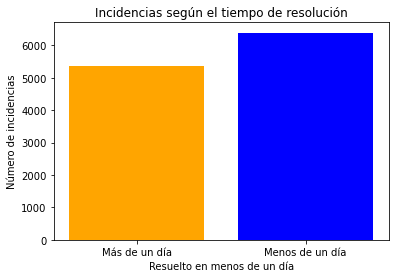

In [18]:
plt.bar(isOnTime_counts.index, isOnTime_counts.values, color=['blue', 'orange'])

# Añadir etiquetas y título
plt.xlabel('Resuelto en menos de un día')
plt.ylabel('Número de incidencias')
plt.title('Incidencias según el tiempo de resolución')

# Personalizar las etiquetas del eje x
plt.xticks(isOnTime_counts.index, ['Menos de un día', 'Más de un día'])

# Mostrar el gráfico
plt.show()

<AxesSubplot:ylabel='Is On Time'>

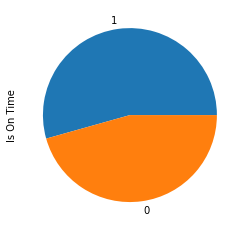

In [19]:
isOnTime_counts.plot.pie()

In [20]:
columns_list = combined_df.columns
columns_list = [elem for elem in columns_list if elem not in ['Incident Number', 'Is On Time']] 
combined_df_one_hot = pd.get_dummies(combined_df, columns=columns_list)
combined_df_one_hot.shape

(11755, 1561)

In [21]:
X = combined_df_one_hot.drop(['Incident Number', 'Is On Time'], axis=1).values
y = combined_df_one_hot['Is On Time'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

In [22]:
if (sklearn.__version__ < "1.1.0"):
    funcion_coste = 'log'
else:
    funcion_coste = 'log_loss'
funcion_coste

'log_loss'

Precisión (Acurracy) :  85.62%
Puntuación de validación cruzada(Cross Validation Score) con Train :  94.83%
Puntuación ROC_AUC :  85.08%


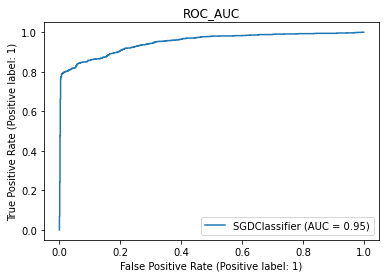

              precision    recall  f1-score   support

           0       0.88      0.79      0.83      1074
           1       0.84      0.91      0.87      1277

    accuracy                           0.86      2351
   macro avg       0.86      0.85      0.85      2351
weighted avg       0.86      0.86      0.86      2351



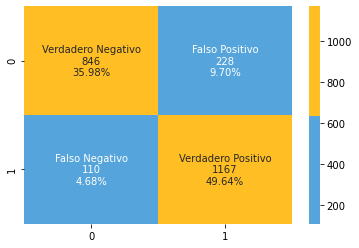

In [23]:
log_classifier = SGDClassifier(loss=funcion_coste,  fit_intercept=True, random_state=RANDOM_STATE)

log_classifier.fit(X_train, y_train)
prediction = log_classifier.predict(X_test)
accuracy = accuracy_score(y_test, prediction)

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)

print("Precisión (Acurracy) : ",'{0:.2%}'.format(accuracy_score(y_test,prediction)))
print("Puntuación de validación cruzada(Cross Validation Score) con Train : ",'{0:.2%}'.format(cross_val_score(log_classifier,X_train,y_train, cv = cv ,scoring = 'roc_auc').mean()))
#print("Puntuación de validación cruzada(Cross Validation Score) con Val : ",'{0:.2%}'.format(cross_val_score(log_classifier,X_val_OH_sc,y_val_OH, cv = cv ,scoring = 'roc_auc').mean()))
print("Puntuación ROC_AUC : ",'{0:.2%}'.format(roc_auc_score(y_test,prediction)))

RocCurveDisplay.from_estimator(log_classifier, X_test,y_test)
plt.title('ROC_AUC')
plt.show()

colores = ['#55A4DB','#FFBF24']
# Matriz de confusión

cm = confusion_matrix(y_test, prediction)
nombres = ['Verdadero Negativo','Falso Positivo','Falso Negativo','Verdadero Positivo']
counts = [value for value in cm.flatten()]
porcentajes = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
etiquetas = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(nombres,counts,porcentajes)]
etiquetas = np.asarray(etiquetas).reshape(2,2)
sns.heatmap(cm,annot = etiquetas,cmap = colores,fmt ='')

# Informe con clasificaciones
print(classification_report(y_test, prediction))


Precisión (Acurracy) :  88.64%
Puntuación ROC_AUC :  89.08%


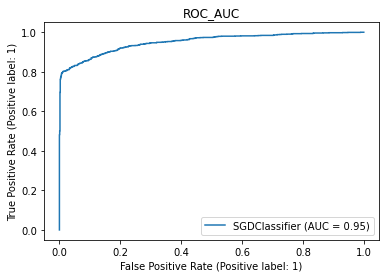

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      1095
           1       0.95      0.83      0.89      1256

    accuracy                           0.89      2351
   macro avg       0.89      0.89      0.89      2351
weighted avg       0.90      0.89      0.89      2351



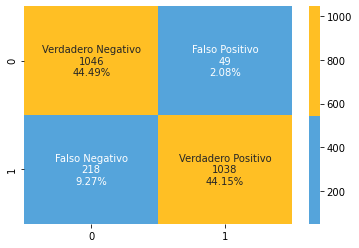

In [24]:
RANDOM_STATE = 9678
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
log_classifier = SGDClassifier(loss=funcion_coste,  fit_intercept=True, random_state=RANDOM_STATE)

log_classifier.fit(X_train, y_train)
prediction = log_classifier.predict(X_test)
accuracy = accuracy_score(y_test, prediction)

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)

print("Precisión (Acurracy) : ",'{0:.2%}'.format(accuracy_score(y_test,prediction)))
#print("Puntuación de validación cruzada(Cross Validation Score) con Train : ",'{0:.2%}'.format(cross_val_score(log_classifier,X_train,y_train, cv = cv ,scoring = 'roc_auc').mean()))
#print("Puntuación de validación cruzada(Cross Validation Score) con Val : ",'{0:.2%}'.format(cross_val_score(log_classifier,X_val_OH_sc,y_val_OH, cv = cv ,scoring = 'roc_auc').mean()))
print("Puntuación ROC_AUC : ",'{0:.2%}'.format(roc_auc_score(y_test,prediction)))

RocCurveDisplay.from_estimator(log_classifier, X_test,y_test)
plt.title('ROC_AUC')
plt.show()

colores = ['#55A4DB','#FFBF24']
# Matriz de confusión

cm = confusion_matrix(y_test, prediction)
nombres = ['Verdadero Negativo','Falso Positivo','Falso Negativo','Verdadero Positivo']
counts = [value for value in cm.flatten()]
porcentajes = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
etiquetas = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(nombres,counts,porcentajes)]
etiquetas = np.asarray(etiquetas).reshape(2,2)
sns.heatmap(cm,annot = etiquetas,cmap = colores,fmt ='')

# Informe con clasificaciones
print(classification_report(y_test, prediction))
